In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import defaultdict

plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

In [22]:
results_df = pd.read_csv("../results/c-terminal-extension/final_candidates.tsv", sep='\t')

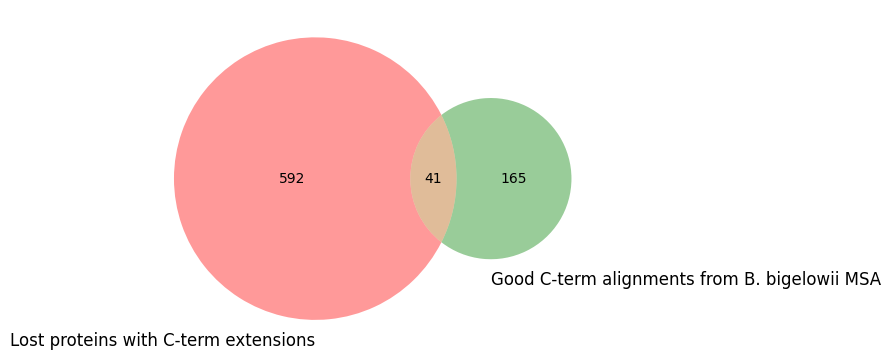

In [23]:
extension_ids = set(results_df['qseqid'])

good_c_term = SeqIO.parse('../data/good-c-term-full.fasta', 'fasta')
good_c_term_ids = set([seq.id for seq in good_c_term])

import matplotlib_venn

matplotlib_venn.venn2([extension_ids, good_c_term_ids], ('Lost proteins with C-term extensions', 'Good C-term alignments from B. bigelowii MSA'))

In [ ]:
bb_seqs = { s.id: s for s in SeqIO.parse('../data/ADK1075_proteomics_DB_2.fasta', 'fasta') }
bb_seq_ids = set(bb_seqs.keys())

# Filter out good c-term alignments and extensions that are not in the B. bigelowii MSA
bb_no_extension_ids = bb_seq_ids - extension_ids - good_c_term_ids

bb_no_extension_seqs = [bb_seqs[i] for i in bb_no_extension_ids]

# Write the sequences to a fasta file
SeqIO.write(bb_no_extension_seqs, '../data/bb_no_extension_seqs.fasta', 'fasta')



43565

In [17]:
# Calculate extension lengths
results_df['extension_length'] = results_df['qlen'] - results_df['qend']
results_df['target_length'] = results_df['slen']

In [19]:
# q: crocosphera; t: bigelowii
results_df['q_base_length'] = results_df['qlen'] - results_df['extension_length']
results_df['base_identity'] = ((results_df["qend"] - results_df['qstart']) - results_df['mismatch']) / results_df['q_base_length']

In [21]:
(results_df['base_identity'] > 0.5).sum()

np.int64(16)

/var/folders/xd/wcxw_5hn6rz2brc42jwv7f7r0000gn/T/ipykernel_364/997186950.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


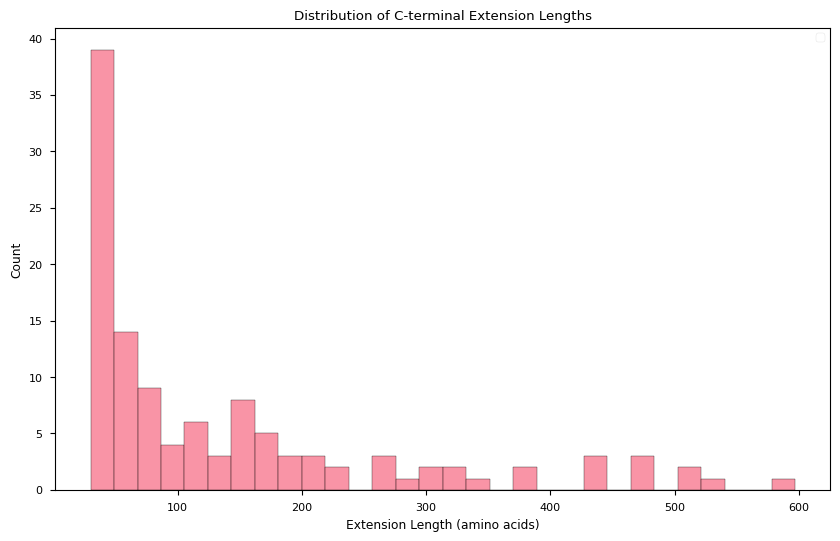

In [18]:
# 1. Distribution of extension lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='extension_length', bins=30)
plt.title('Distribution of C-terminal Extension Lengths')
plt.xlabel('Extension Length (amino acids)')
plt.ylabel('Count')
# plt.axvline(x=30, color='r', linestyle='--', label='Minimum threshold')
plt.legend()
plt.show()

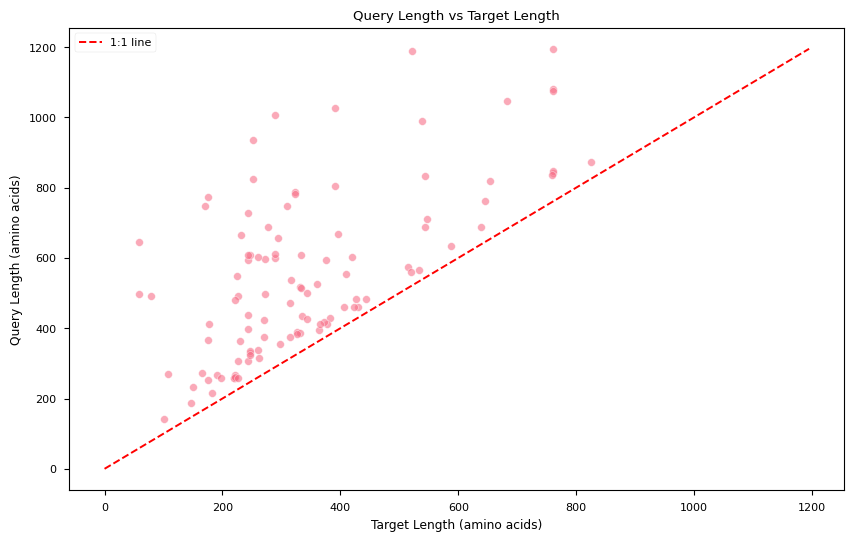

In [8]:
# 2. Scatter plot of query vs target lengths
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='target_length', y='qlen', alpha=0.6)
plt.plot([0, max(results_df['qlen'])], [0, max(results_df['qlen'])], 
         'r--', label='1:1 line')
plt.title('Query Length vs Target Length')
plt.xlabel('Target Length (amino acids)')
plt.ylabel('Query Length (amino acids)')
plt.legend()
plt.show()


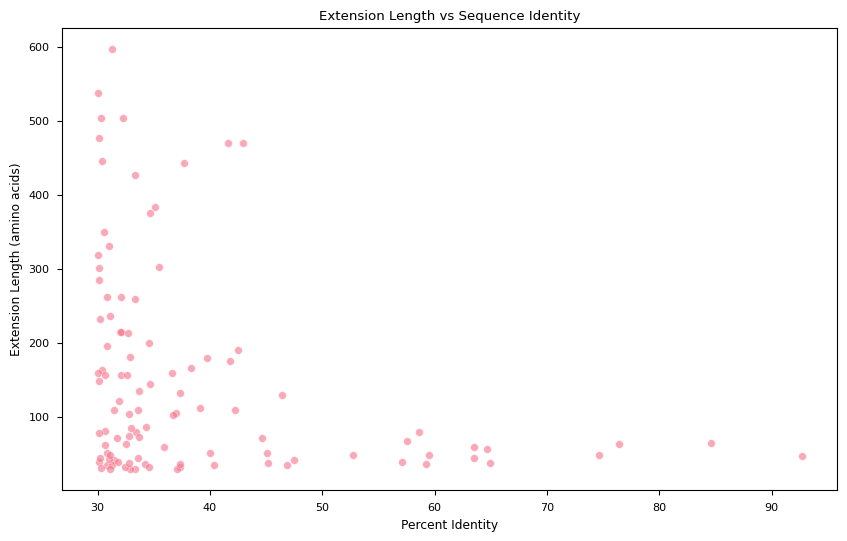

In [9]:
# 3. Relationship between extension length and sequence identity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='pident', y='extension_length', alpha=0.6)
plt.title('Extension Length vs Sequence Identity')
plt.xlabel('Percent Identity')
plt.ylabel('Extension Length (amino acids)')
plt.show()

In [11]:
# 4. Load sequences and analyze properties of extensions
def get_extension_properties(seq):
    """Calculate basic properties of a protein sequence"""
    try:
        analysis = ProteinAnalysis(str(seq))
        return {
            'length': len(seq),
            'molecular_weight': analysis.molecular_weight(),
            'aromaticity': analysis.aromaticity(),
            'instability_index': analysis.instability_index(),
            'gravy': analysis.gravy(),  # Hydropathy
            'charged_residues': (
                analysis.count_amino_acids()['R'] + 
                analysis.count_amino_acids()['K'] + 
                analysis.count_amino_acids()['D'] + 
                analysis.count_amino_acids()['E']
            )
        }
    except:
        return None

# Load extensions and calculate properties
extensions_properties = []
with open("../results/c-terminal-extension/extensions.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        props = get_extension_properties(record.seq)
        if props:
            props['id'] = record.id
            extensions_properties.append(props)

ext_props_df = pd.DataFrame(extensions_properties)

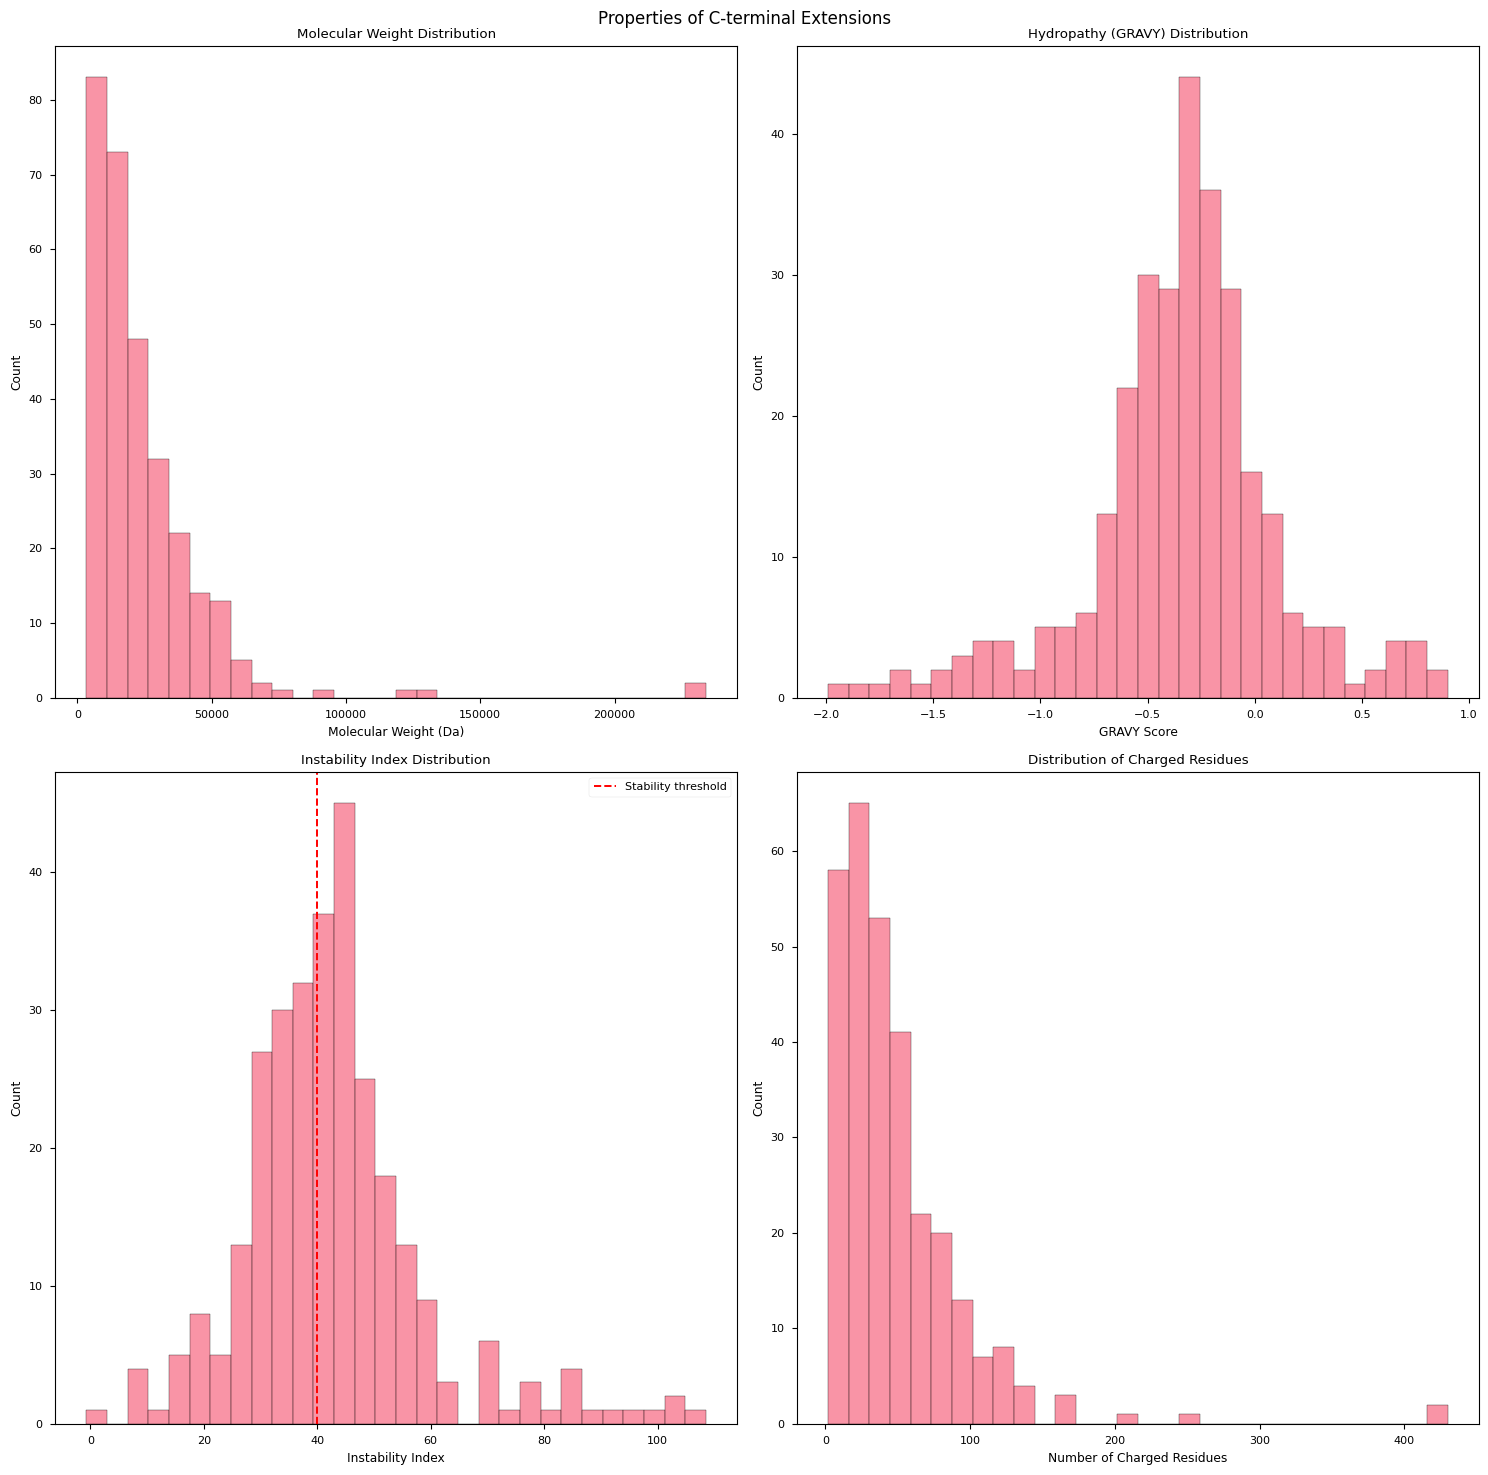

In [12]:

# 5. Plot extension properties
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Properties of C-terminal Extensions')

# Molecular weight distribution
sns.histplot(data=ext_props_df, x='molecular_weight', bins=30, ax=axes[0,0])
axes[0,0].set_title('Molecular Weight Distribution')
axes[0,0].set_xlabel('Molecular Weight (Da)')

# Hydropathy (GRAVY) distribution
sns.histplot(data=ext_props_df, x='gravy', bins=30, ax=axes[0,1])
axes[0,1].set_title('Hydropathy (GRAVY) Distribution')
axes[0,1].set_xlabel('GRAVY Score')

# Instability index
sns.histplot(data=ext_props_df, x='instability_index', bins=30, ax=axes[1,0])
axes[1,0].set_title('Instability Index Distribution')
axes[1,0].set_xlabel('Instability Index')
axes[1,0].axvline(x=40, color='r', linestyle='--', 
                  label='Stability threshold')
axes[1,0].legend()

# Charged residues
sns.histplot(data=ext_props_df, x='charged_residues', bins=30, ax=axes[1,1])
axes[1,1].set_title('Distribution of Charged Residues')
axes[1,1].set_xlabel('Number of Charged Residues')

plt.tight_layout()
plt.show()

In [13]:
# 6. Summary statistics
print("\nSummary Statistics:")
print("-" * 50)
print("\nExtension Lengths:")
print(results_df['extension_length'].describe())
print("\nSequence Identity:")
print(results_df['pident'].describe())
print("\nExtension Properties:")
print(ext_props_df[['molecular_weight', 'gravy', 
                    'instability_index', 'charged_residues']].describe())

# 7. Calculate and display proportions of stable vs unstable extensions
stable_proportion = (ext_props_df['instability_index'] < 40).mean() * 100
print(f"\nProportion of stable extensions: {stable_proportion:.1f}%")



Summary Statistics:
--------------------------------------------------

Extension Lengths:
count    105.000000
mean     151.238095
std      140.726653
min       30.000000
25%       45.000000
50%       87.000000
75%      200.000000
max      597.000000
Name: extension_length, dtype: float64

Sequence Identity:
count    105.000000
mean      38.617143
std       12.422030
min       30.000000
25%       31.100000
50%       33.300000
75%       40.000000
max       92.700000
Name: pident, dtype: float64

Extension Properties:
       molecular_weight       gravy  instability_index  charged_residues
count        298.000000  298.000000         298.000000        298.000000
mean       23828.773825   -0.342426          42.891641         48.862416
std        24709.239798    0.448431          16.057667         47.851952
min         3339.723900   -1.990909          -0.706250          2.000000
25%         9321.462325   -0.529231          33.602543         19.250000
50%        18203.669100   -0.306625    